In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [2]:
DATASET_PATH = "/kaggle/input/garbage-classification-v2/garbage-dataset"
TARGET_SIZE = (128, 128)

def load_image(path):
    img = Image.open(path).convert("L")
    img = img.resize(TARGET_SIZE)
    return np.array(img)

In [3]:
def median_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(img, pad, mode='edge')
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            filtered[i, j] = np.median(region)
    return filtered

In [4]:
def gaussian_filter(img, kernel_size=3, sigma=1.0):
    pad = kernel_size // 2
    ax = np.linspace(-pad, pad, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    padded = np.pad(img, pad, mode='reflect')
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            filtered[i, j] = np.sum(region * kernel)
    return filtered.astype(np.uint8)

In [5]:
def histogram_equalization(img):
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
    cdf_final = np.ma.filled(cdf_norm, 0).astype('uint8')
    return cdf_final[img]

In [6]:
def contrast_stretching(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) * 255 / (max_val - min_val)
    return stretched.astype(np.uint8)

In [7]:
def preprocess_image(image_path):
    img = load_image(image_path)
    
    img_median = median_filter(img)
    img_gaussian = gaussian_filter(img)
    img_eq = histogram_equalization(img)
    img_contrast = contrast_stretching(img)

    return img, img_median, img_gaussian, img_eq, img_contrast

In [8]:
sample_img_path = str(list(Path(f"{DATASET_PATH}/plastic").glob("*.jpg"))[0])
original, medianed, gauss, equalized, stretched = preprocess_image(sample_img_path)

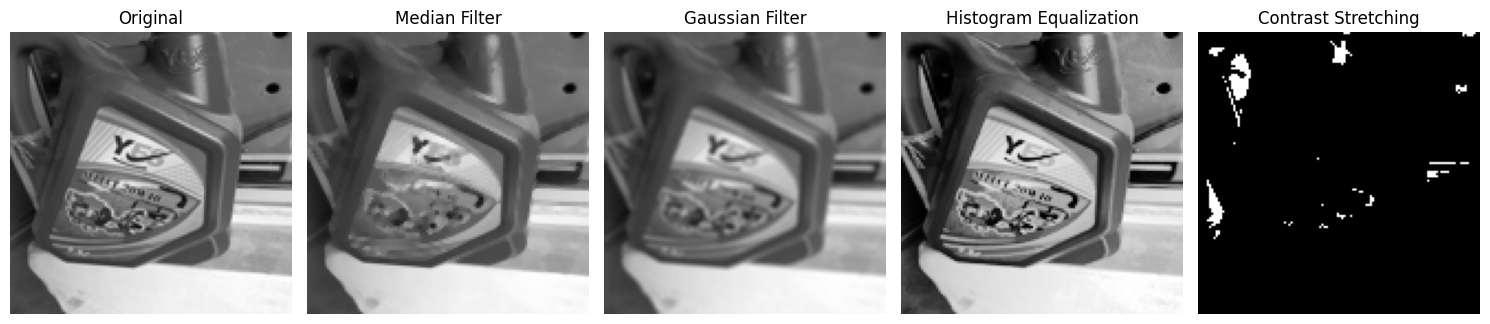

In [9]:
titles = ['Original', 'Median Filter', 'Gaussian Filter', 'Histogram Equalization', 'Contrast Stretching']
images = [original, medianed, gauss, equalized, stretched]

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from scipy.stats import kurtosis, skew
import cv2

In [31]:
def to_grayscale(image_np):
    return 0.2989 * image_np[:, :, 0] + 0.5870 * image_np[:, :, 1] + 0.1140 * image_np[:, :, 2]

In [32]:
def extract_shape_features(img_np):
    gray = to_grayscale(img_np)
    mean = np.mean(gray)
    var = np.var(gray)
    return [mean, var]

In [12]:
def extract_texture_features(img_np):
    gray = to_grayscale(img_np)
    diff = gray[:, 1:] - gray[:, :-1]
    mean_diff = np.mean(np.abs(diff))
    std_diff = np.std(diff)
    return [mean_diff, std_diff]

In [13]:
def extract_statistical_features(img_np):
    means = np.mean(img_np, axis=(0, 1))
    stds = np.std(img_np, axis=(0, 1))
    return means.tolist() + stds.tolist()

In [33]:
def extract_edge_features(img_np):
    gray = to_grayscale(img_np)
    sobel_x = np.zeros_like(gray)
    sobel_y = np.zeros_like(gray)

    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            gx = (-1 * gray[i-1][j-1] + 1 * gray[i-1][j+1]
                  -2 * gray[i][j-1] + 2 * gray[i][j+1]
                  -1 * gray[i+1][j-1] + 1 * gray[i+1][j+1])
            gy = (-1 * gray[i-1][j-1] -2 * gray[i-1][j] -1 * gray[i-1][j+1]
                   +1 * gray[i+1][j-1] +2 * gray[i+1][j] +1 * gray[i+1][j+1])
            sobel_x[i, j] = gx
            sobel_y[i, j] = gy

    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edge_mean = np.mean(edge_magnitude)
    edge_std = np.std(edge_magnitude)
    return [edge_mean, edge_std]

In [15]:
def extract_features(pil_image):
    image_np = np.array(pil_image.resize((128, 128))) / 255.0  # Normalisasi 0-1

    shape_feats = extract_shape_features(image_np)
    texture_feats = extract_texture_features(image_np)
    statistical_feats = extract_statistical_features(image_np)
    edge_feats = extract_edge_features(image_np)

    return shape_feats + texture_feats + statistical_feats + edge_feats

In [16]:
np.random.seed(0)
dummy_image = (np.random.rand(128, 128) * 255).astype(np.uint8)
extract_features(dummy_image)

[7656.0,
 6457.008727101711,
 1.0,
 10933.834092027559,
 0.006796585453921708,
 14.529662110267099,
 0.012089058033813993,
 125.56304931640625,
 73.84455375659239,
 0.02294480047135768,
 -1.2021705231701985,
 0.37237548828125]

In [17]:
features = extract_features(gauss)
print("Extracted Features:", features)

Extracted Features: [3.0, 3.414213562373095, 1.0, 66.28623277559055, 0.02813190554625989, 11.428456821946654, 0.34821184632957236, 121.6678466796875, 54.40677076818478, 0.666256941703427, -0.6527927754488041, 0.10174560546875]


In [18]:
import os
from pathlib import Path
from tqdm import tqdm

In [19]:
LABELS = {
    'battery': 0,
    'biological': 1,
    'cardboard': 2,
    'clothes': 3,
    'glass': 4,
    'metal': 5,
    'paper': 6,
    'plastic': 7,
    'shoes': 8,
    'trash': 9
}

In [20]:
def build_dataset(dataset_path):
    X = []
    y = []

    for label_name, label_id in LABELS.items():
        folder_path = Path(dataset_path) / label_name
        image_paths = list(folder_path.glob("*.jpg"))

        for img_path in tqdm(image_paths, desc=f"Processing {label_name}"):
            try:
                img = load_image(img_path)
                img = gaussian_filter(img)
                features = extract_features(img)
                X.append(features)
                y.append(label_id)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return np.array(X), np.array(y)

In [21]:
dataset_path = "/kaggle/input/garbage-classification-v2/garbage-dataset"
X, y = build_dataset(dataset_path)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Processing trash: 100%|██████████| 938/938 [01:41<00:00,  9.28it/s]

Shape of X: (19730, 12)
Shape of y: (19730,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

Accuracy: 0.5327

Classification Report:
              precision    recall  f1-score   support

     battery       0.60      0.47      0.53       189
  biological       0.44      0.34      0.38       199
   cardboard       0.50      0.48      0.49       365
     clothes       0.60      0.91      0.72      1065
       glass       0.49      0.53      0.51       611
       metal       0.45      0.22      0.30       203
       paper       0.49      0.31      0.38       336
     plastic       0.42      0.35      0.38       395
       shoes       0.43      0.27      0.33       395
       trash       0.63      0.44      0.52       188

    accuracy                           0.53      3946
   macro avg       0.50      0.43      0.45      3946
weighted avg       0.52      0.53      0.51      3946



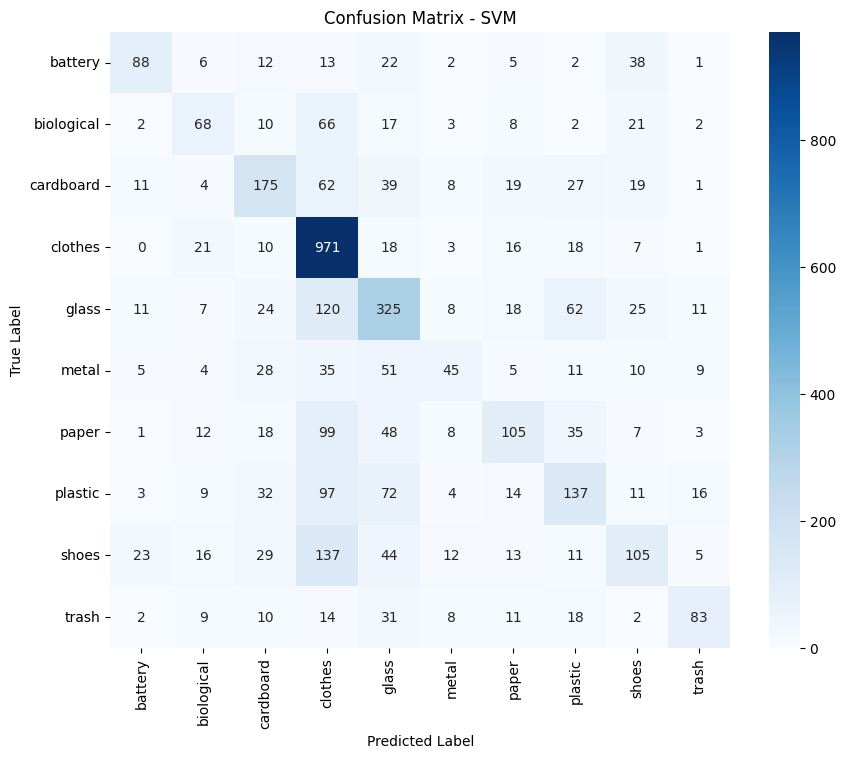

In [26]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS.keys()))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATASET_PATH = "/kaggle/input/garbage-classification-v2/garbage-dataset"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes

Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


In [37]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 270s 527ms/step - accuracy: 0.6891 - loss: 0.9814 - val_accuracy: 0.8797 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 246s 497ms/step - accuracy: 0.8783 - loss: 0.3762 - val_accuracy: 0.8939 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 261s 527ms/step - accuracy: 0.8917 - loss: 0.3275 - val_accuracy: 0.8916 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 240s 485ms/step - accuracy: 0.8932 - loss: 0.3119 - val_accuracy: 0.8947 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 240s 485ms/step - accuracy: 0.8978 - loss: 0.3115 - val_accuracy: 0.8990 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 239s 483ms/step - accuracy: 0.9091 - loss: 0.2699 - val_accuracy: 0.8969 - val_loss: 0.3157 - learning_rate: 0.0010
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 248s 502ms/step - accura

In [39]:
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 276s 515ms/step - accuracy: 0.8301 - loss: 0.5186 - val_accuracy: 0.8939 - val_loss: 0.3336 - learning_rate: 1.0000e-05
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 238s 481ms/step - accuracy: 0.8885 - loss: 0.3421 - val_accuracy: 0.9086 - val_loss: 0.2933 - learning_rate: 1.0000e-05
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 248s 500ms/step - accuracy: 0.8966 - loss: 0.3140 - val_accuracy: 0.9136 - val_loss: 0.2743 - learning_rate: 1.0000e-05
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 238s 480ms/step - accuracy: 0.9116 - loss: 0.2659 - val_accuracy: 0.9162 - val_loss: 0.2766 - learning_rate: 1.0000e-05
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 245s 495ms/step - accuracy: 0.9129 - loss: 0.2590 - val_accuracy: 0.9190 - val_loss: 0.2669 - learning_rate: 1.0000e-05
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 242s 489ms/step - accuracy: 0.9241 - loss: 0.2296 - val_accuracy: 0.9167 - val_loss: 0.2539 - learning_rate: 1.0000e-05
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 

124/124 ━━━━━━━━━━━━━━━━━━━━ 106s 827ms/step
              precision    recall  f1-score   support

     battery       0.95      0.97      0.96       188
  biological       0.93      0.93      0.93       199
   cardboard       0.91      0.95      0.93       365
     clothes       0.98      0.98      0.98      1065
       glass       0.93      0.91      0.92       612
       metal       0.85      0.85      0.85       204
       paper       0.91      0.90      0.90       336
     plastic       0.86      0.87      0.87       396
       shoes       0.95      0.96      0.95       395
       trash       0.83      0.75      0.79       189

    accuracy                           0.93      3949
   macro avg       0.91      0.91      0.91      3949
weighted avg       0.93      0.93      0.93      3949



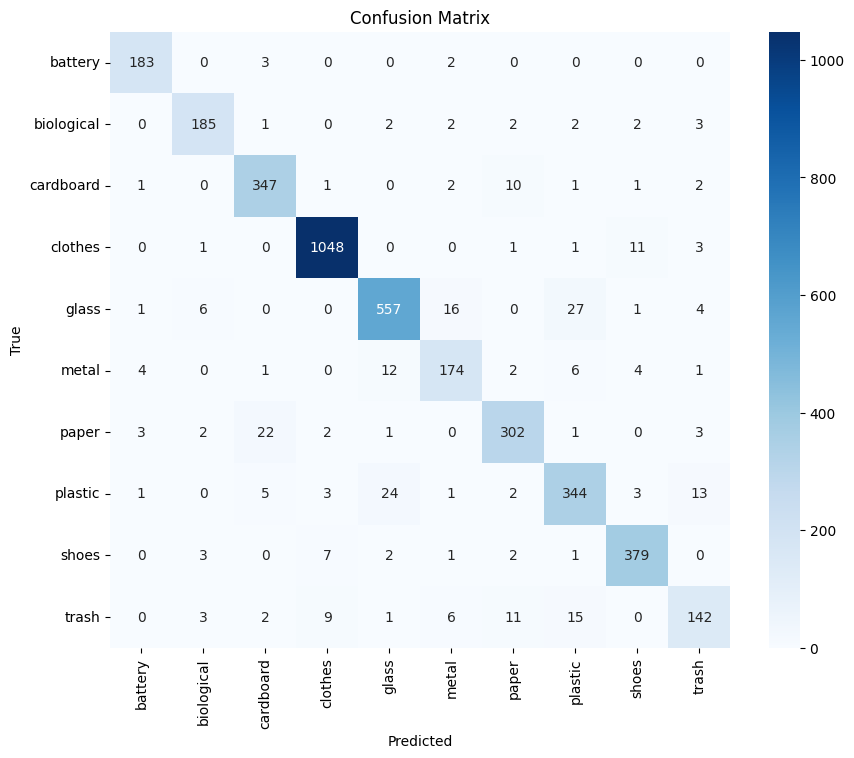

In [40]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 902ms/step
              precision    recall  f1-score   support

     battery       0.96      0.97      0.97       188
  biological       0.95      0.94      0.95       199
   cardboard       0.91      0.95      0.93       365
     clothes       0.98      0.99      0.98      1065
       glass       0.92      0.93      0.93       612
       metal       0.84      0.85      0.85       204
       paper       0.93      0.89      0.91       336
     plastic       0.85      0.86      0.85       396
       shoes       0.94      0.95      0.95       395
       trash       0.79      0.71      0.75       189

    accuracy                           0.93      3949
   macro avg       0.91      0.90      0.91      3949
weighted avg       0.93      0.93      0.93      3949



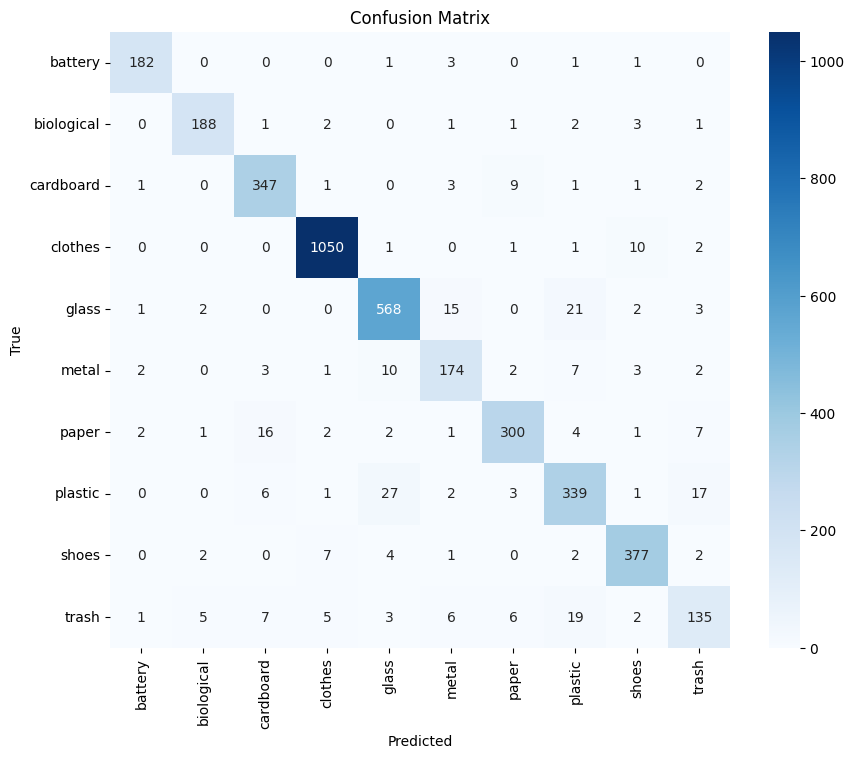

In [41]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

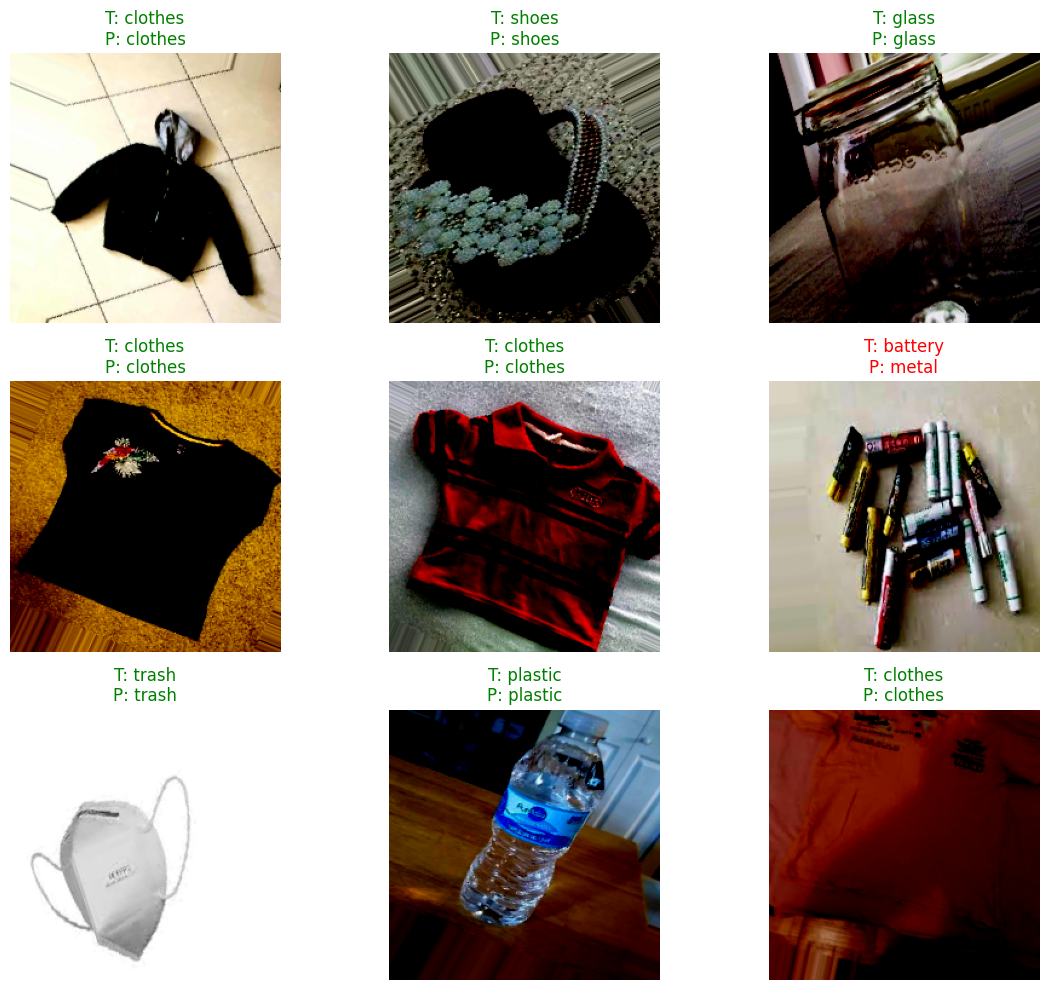

In [42]:
import random

X_test_cnn = []
for i in range(len(val_gen)):
    x_batch, _ = val_gen[i]
    X_test_cnn.extend(x_batch)
X_test_cnn = np.array(X_test_cnn)

y_test_cnn = y_true
y_pred_labels = y_pred

def show_predictions(images, true_labels, pred_labels, class_names, num_samples=9):
    plt.figure(figsize=(12, 10))
    indices = random.sample(range(len(images)), num_samples)

    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx])
        true = class_names[true_labels[idx]]
        pred = class_names[pred_labels[idx]]
        color = 'green' if true == pred else 'red'
        plt.title(f"T: {true}\nP: {pred}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(X_test_cnn, y_test_cnn, y_pred_labels, list(LABELS.keys()))

In [44]:
import os

os.makedirs("model", exist_ok=True)

model.save("model/cnn_model.keras", save_format="keras")

In [49]:
model.save_weights("model/cnn_model.weights.h5")

In [45]:
import joblib
joblib.dump(svm, "model/svm_model.pkl")

['model/svm_model.pkl']